In [450]:
import os
import cv2
import glob
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import misc
import numpy as np
from torchvision.transforms import *
import matplotlib.pyplot as plt
%matplotlib inline

### visualize data

In [1]:
save_dir = './data'

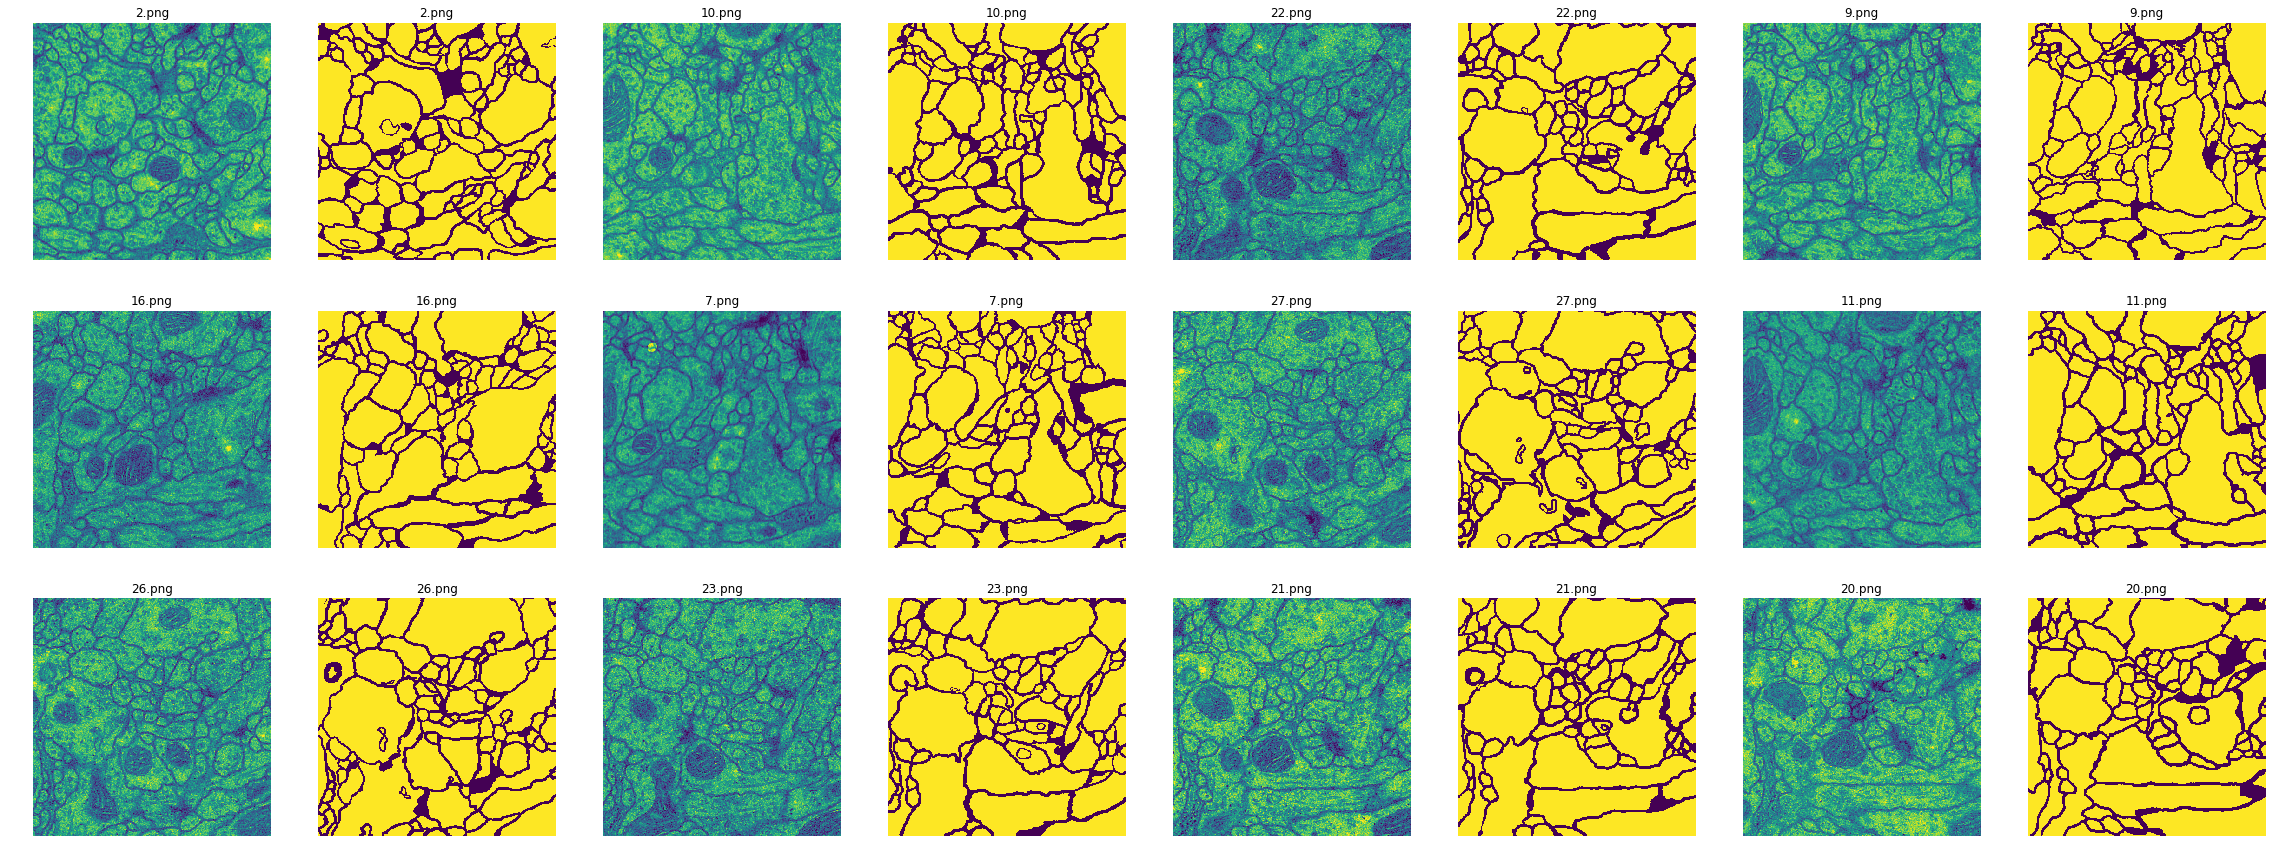

In [452]:
img_dir = os.path.join(save_dir, 'train', 'image')
lab_dir = os.path.join(save_dir, 'train', 'label')
img_fns = os.listdir(img_dir)
f, axarr = plt.subplots(3, 8, figsize=(40, 15))
indexs = random.sample(range(len(img_fns)), 12)

for (i, index) in enumerate(indexs):
    img_fn = img_fns[index]
    lab_fn = img_fn
    img_path = os.path.join(img_dir, img_fn)
    label_path = os.path.join(lab_dir, lab_fn)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)[np.newaxis, :][0]
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)[np.newaxis, :][0] * 255.
    axarr[i*2//8][i*2%8].axis('off')
    axarr[i*2//8][i*2%8].set_title(img_fn)
    axarr[i*2//8][i*2%8].imshow(img)
    axarr[(i*2+1)//8][(i*2+1)%8].axis('off')
    axarr[(i*2+1)//8][(i*2+1)%8].set_title(lab_fn)
    axarr[(i*2+1)//8][(i*2+1)%8].imshow(label) 

### u-net

In [453]:
def conv3x3(in_channels, out_channels, stride=1, padding=1, activate='relu'):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding))
    layers.append(nn.BatchNorm2d(out_channels))
    if activate == 'relu':
        layers.append(nn.ReLU(inplace=True))
    elif activate == 'sigmoid':
        layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

In [464]:
def double_conv3x3(in_channels, out_channels, stride=1, padding=1, activate='relu'):
    return nn.Sequential(
        conv3x3(in_channels, out_channels, stride, padding=1, activate=activate),
        conv3x3(out_channels, out_channels, stride, padding=1, activate=activate))

In [465]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSample, self).__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            double_conv3x3(in_channels, out_channels))
    
    def forward(self, x):
        return self.net(x)

In [466]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(UpSample, self).__init__()
        self.bilinear = bilinear
        self.conv_trans = nn.ConstantPad2d(in_channels, out_channels, 2, strides=2)
        self.net = double_conv3x3(in_channels, out_channels)
        
    def forward(self, front, later):
        if self.bilinear:
            later = F.interpolate(later, scale_factor=2, mode='bilinear', align_corners=True)
        else:
            later = self.conv_trans(later)
        h_diff = front.size()[2] - later.size()[2]
        w_diff = front.size()[3] - later.size()[3]
        later = F.pad(later, pad=(w_diff//2,w_diff-w_diff//2,h_diff//2,h_diff-h_diff//2), mode='constant',value=0)
        x = torch.cat([front, later], dim=1)
        x = self.net(x)
        return x

In [469]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.inconv = double_conv3x3(1, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outconv = double_conv3x3(64, 1, activate='sigmoid')
        
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
    def forward(self, x):
        x1 = self.inconv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x4, x5)
        x = self.up2(x3, x)
        x = self.up3(x2, x)
        x = self.up4(x1, x)
        x = self.outconv(x)

        return x


### data loader

In [471]:
import torch.utils.data as data
from torch.utils.data.dataset import Dataset 
class Loader(Dataset):
    def __init__(self, split, save_dir):
        image_dir = os.path.join(save_dir, split, 'image')
        label_dir = os.path.join(save_dir, split, 'label')
        self.images, self.labels = self._read_data(image_dir, label_dir)
        self.trans = Compose([
            ToPILImage(),
            RandomHorizontalFlip(0.5),
            RandomVerticalFlip(0.5),
            RandomResizedCrop(572),
            ToTensor()])
    
    def _read_data(self, image_dir, label_dir):
        images, labels = [], []
        img_fns = os.listdir(image_dir)
        for img_fn in img_fns:
            image_path = os.path.join(image_dir, img_fn)
            label_path = os.path.join(label_dir, img_fn)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.
            images.append(image[np.newaxis,:])
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE) / 255.
            label[label > 0.5] = 1
            label[label <= 0.5] = 0
            labels.append(label[np.newaxis,:])
        return images, labels
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if np.random.uniform(0, 1) < 0.5:
            image = image[:, ::-1, :]
            label = label[:, ::-1, :]
        if np.random.uniform(0, 1) < 0.5:
            image = image[:, :, ::-1]
            label = label[:, :, ::-1]
        
        image = np.ascontiguousarray(image)
        label = np.ascontiguousarray(label)
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
        
        return image, label
    
    def __len__(self):
        return len(self.images)

### functions

In [472]:
import torch.nn.functional as F 
def accuracy(logit, target, threshold=0.5):
    logit[logit > threshold] = 1
    logit[logit <= threshold] = 0
    return (logit.long() == target.long()).float().mean().item()

In [473]:
def adjust_lr(optimizer, lr_gamma=0.1):
    for (i, param_group) in enumerate(optimizer.param_groups):
        param_group['lr'] = param_group['lr'] * lr_gamma
    return optimizer.state_dict()['param_groups'][0]['lr']

### train

In [474]:
import torch
import torch.nn as nn
import torch.optim as optim
import os

def step(split, epoch, model, criterion, optimizer, batch_size=1, cuda=False):
    
    if split == 'train':
        model.train()
    else:
        model.eval()

    loader = data.DataLoader(Loader(split, save_dir), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    epoch_loss, epoch_acc, n_batchs = 0, 0, 0
    for i, (image, label) in enumerate(loader):
        n_batchs += image.size(0)
        if cuda:
            image = image.cuda()
            label = label.cuda()
        logit = model(image)
        logit = logit.flatten()
        label = label.flatten()
        loss = criterion(logit, label)
        if split == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += accuracy(logit, label) * 100
    epoch_loss /= n_batchs
    epoch_acc /= n_batchs
    return epoch_loss, epoch_acc

In [475]:
batch_size = 1
pretrained = False
cuda = True
start_epoch = 2
end_epoch = 60
lr_decay = 30

In [476]:
criterion = nn.BCEWithLogitsLoss()
model = UNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.99, weight_decay=0.0005)
if cuda:
    model = model.cuda()
    criterion = criterion.cuda()
if pretrained:
    model.load_state_dict(torch.load('model.pth'))
train_losses, val_losses = [], []
for epoch in range(start_epoch, end_epoch):
    if epoch % lr_decay == 0:
        lr = adjust_lr(optimizer)
        print('adjust LR to {:.4f}'.format(lr))
    tepoch_loss, tepoch_acc = step('train', epoch, model, criterion, optimizer, batch_size, cuda=cuda)
    vepoch_loss, vepoch_acc = step('val', epoch, model, criterion, optimizer, batch_size, cuda=cuda)
    train_losses.append(tepoch_loss)
    val_losses.append(vepoch_loss)
    print('epoch {0:} finished, tloss:{1:.4f} [{2:.2f}%]  vloss:{3:.4f} [{4:.2f}%]'.format(epoch, tepoch_loss, tepoch_acc, vepoch_loss, vepoch_acc))
torch.save(model.state_dict(), 'model.pth')
print('done!')

epoch 2 finished, tloss:0.5536 [64.98%]  vloss:0.5125 [81.56%]
epoch 3 finished, tloss:0.5218 [79.81%]  vloss:0.4900 [86.01%]
epoch 4 finished, tloss:0.5004 [83.21%]  vloss:0.4691 [86.16%]
epoch 5 finished, tloss:0.4809 [86.44%]  vloss:0.4564 [87.06%]
epoch 6 finished, tloss:0.4680 [88.22%]  vloss:0.4442 [89.49%]
epoch 7 finished, tloss:0.4598 [88.81%]  vloss:0.4394 [89.12%]
epoch 8 finished, tloss:0.4539 [89.52%]  vloss:0.4357 [90.83%]
epoch 9 finished, tloss:0.4500 [89.90%]  vloss:0.4471 [89.38%]
epoch 10 finished, tloss:0.4478 [90.09%]  vloss:0.4340 [90.76%]
epoch 11 finished, tloss:0.4455 [90.38%]  vloss:0.4291 [90.43%]
epoch 12 finished, tloss:0.4432 [90.88%]  vloss:0.4277 [91.60%]
epoch 13 finished, tloss:0.4417 [90.93%]  vloss:0.4296 [91.28%]
epoch 14 finished, tloss:0.4402 [91.27%]  vloss:0.4268 [91.67%]
epoch 15 finished, tloss:0.4398 [91.29%]  vloss:0.4286 [91.31%]
epoch 16 finished, tloss:0.4390 [91.36%]  vloss:0.4280 [91.57%]
epoch 17 finished, tloss:0.4391 [91.50%]  vloss:

### visualize output

Text(0, 0.5, 'loss')

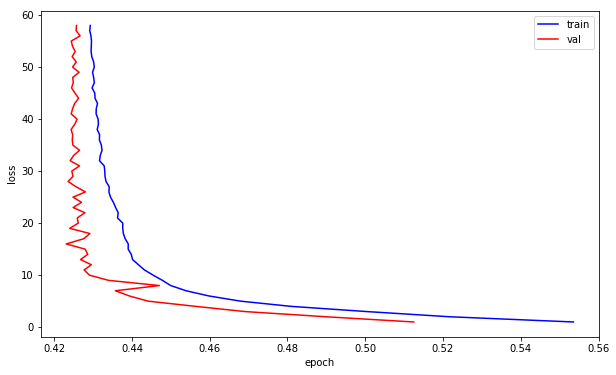

In [477]:
fig = plt.figure(figsize=(10, 6))
plt.plot(train_losses, range(1, len(train_losses)+1), c='blue', label='train')
plt.plot(val_losses, range(1, len(val_losses)+1), c='red', label='val')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')

Loss: 0.4330 [91.74%]


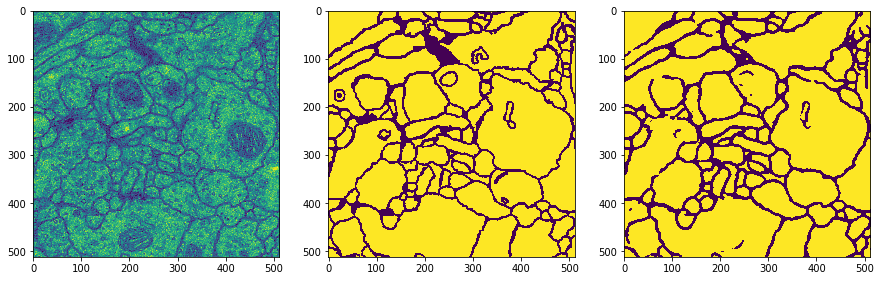

In [491]:
model.load_state_dict(torch.load('model.pth'))
loader = data.DataLoader(Loader('val', save_dir), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
for (img, lab) in loader:
    if cuda:
        img = img.cuda()
        lab = lab.cuda()
    out = model(img)
    print('Loss: {:.4f} [{:.2f}%]'.format(criterion(out, lab).item(), accuracy(out, lab) * 100.))
    out = torch.sigmoid(out)
    out[out > 0.5] = 1
    out[out <= 0.5] = 0
    out = out.detach().cpu().numpy()[0, 0] * 255.
    show_img = img.cpu().numpy()[0, 0]
    show_lab = lab.cpu().numpy()[0, 0] * 255.
    f, axarr = plt.subplots(1, 3, figsize=(15, 5))
    axarr[0].imshow(show_img)
    axarr[1].imshow(show_lab)
    axarr[2].imshow(out)
    break